In [1]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import pickle 

In [2]:
#df_path = '~/Documents/GitHub/metis_coursework/project_1/data/Turnstile_Usage_Data__2019.csv' #your own path of the file
df_path = '~/Documents/GitHub/Metis_project1/Turnstile_Usage_Data__2019.csv'

df = pd.read_csv(df_path,header = 0)

In [3]:
#simple understanding of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10467101 entries, 0 to 10467100
Data columns (total 11 columns):
C/A                                                           object
Unit                                                          object
SCP                                                           object
Station                                                       object
Line Name                                                     object
Division                                                      object
Date                                                          object
Time                                                          object
Description                                                   object
Entries                                                       int64
Exits                                                         int64
dtypes: int64(2), object(9)
memory usage: 878.4+ MB


In [ ]:
df.head()

In [4]:
#create unique turnstile id for each turnstile
df['Turnstile_ID'] = df['Unit'].astype(str) + "_"+ df['SCP'].astype(str) +"_"+ df['Station'].astype(str) 

In [5]:
#clean up column name
df.rename(columns = {'Exits                                                     ':'Exits'},inplace = True)

In [6]:
#trim dataset so that it runs faster
columns_to_keep = ['Turnstile_ID','Station','Date','Time','Entries','Exits']
df_new = pd.DataFrame(df[columns_to_keep])

In [7]:
#convert date and time into datetime format
df_new['Date'] = df_new.Date.apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y').date())
df_new['Time'] = df_new.Time.apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S').time())

In [8]:
df_new.head()

,Turnstile_ID,Station,Date,Time,Entries,Exits
0,R170_02-06-00_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,769115,559221
1,R170_02-00-04_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,6483080,4945335
2,R170_02-00-03_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,7191422,8417203
3,R170_02-00-02_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,14983900,14554087
4,R170_02-06-01_14 ST-UNION SQ,14 ST-UNION SQ,2019-12-27,00:00:00,71047673,20925389


In [8]:
df_new = df_new.sort_values(by = ['Turnstile_ID','Date']).reset_index()


In [10]:
df_new.to_pickle('./data_sorted_wo_diff.pkl')

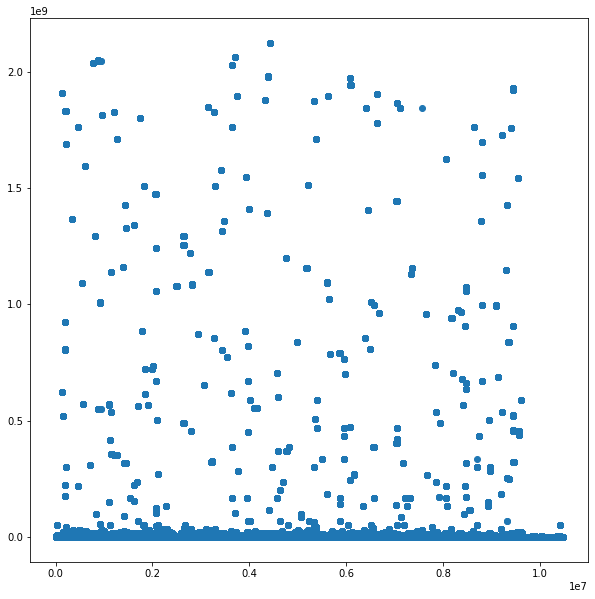

In [16]:
plt.figure(figsize=[10,10])
plt.scatter(df_new.index,df_new.Exits)

{'whiskers': [<matplotlib.lines.Line2D at 0x14f6f2690>,
 'caps': [<matplotlib.lines.Line2D at 0x1a59ded90>,
 'boxes': [<matplotlib.lines.Line2D at 0x1314d2c90>],
 'medians': [<matplotlib.lines.Line2D at 0x257ffca50>],
 'fliers': [<matplotlib.lines.Line2D at 0x257ffc490>],
 'means': []}

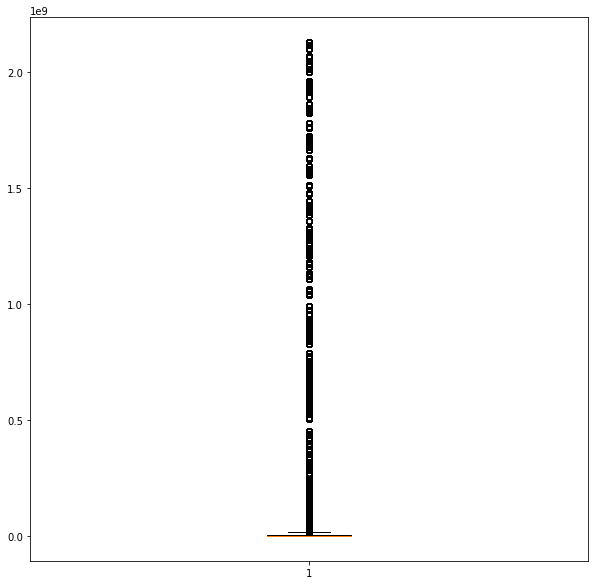

In [15]:
plt.figure(figsize=[10,10])
plt.boxplot(df_new.Entries) #data is very skewed and has many outliners which are extremely high in value

In [19]:
df_new.Entries.sort_values(ascending = False)[:5] #sort entries to understand top five

5178573    2129551969
5178574    2129551904
5178575    2129551874
5178576    2129551796
5178577    2129551507
Name: Entries, dtype: int64

In [68]:
quantile_to_flag = 12150 #assuming 30 pp passing through per minute
total_num_entry = len(df_new)

In [32]:
print(total_num_entry)

10467101


In [16]:
#calculate row wise difference in absolute value (accounting for backwards counting)
df_new['entry_diff_abs'] = df_new.Entries.diff(periods = 1).abs()
df_new['exit_diff_abs'] = df_new.Exits.diff(periods = 1).abs()
#reset the start of every new turnstile
df_new['entry_diff_abs'] = np.where(df_new.Turnstile_ID == df_new.Turnstile_ID.shift(periods = 1,fill_value = 0),
                                df_new.entry_diff_abs,0)
df_new['exit_diff_abs'] = np.where(df_new.Turnstile_ID == df_new.Turnstile_ID.shift(periods = 1,fill_value = 0),
                               df_new.exit_diff_abs,0)

In [69]:
# check for data that is abnormally high
df_new['flag_high_entry_diff'] = df_new['entry_diff_abs'] > quantile_to_flag
df_new['flag_high_exit_diff'] = df_new['exit_diff_abs'] > quantile_to_flag

In [70]:
total_abno = np.sum([df_new.flag_high_entry_diff.sum(),df_new['flag_high_exit_diff'].sum()])
total_abno/total_num_entry*100 #abnormal entries are less than 0.1% of total data, we will discard outliners here

0.08094887017904957

In [71]:
rows_to_drop = df_new[df_new['flag_high_entry_diff']].index.tolist() + df_new[df_new['flag_high_exit_diff']].index.tolist()

In [72]:
df = pd.DataFrame(df_new.drop(rows_to_drop))

In [73]:
df = df.rename(columns = {'entry_diff_abs':'Entry_diff','exit_diff_abs':'Exit_diff'})

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10461006 entries, 0 to 10467100
Data columns (total 14 columns):
index                   int64
Turnstile_ID            object
Station                 object
Date                    object
Time                    object
Entries                 int64
Exits                   int64
Entry_not_increasing    bool
Exit_not_increasing     bool
not_start_day           bool
Entry_diff              float64
Exit_diff               float64
flag_high_entry_diff    bool
flag_high_exit_diff     bool
dtypes: bool(5), float64(2), int64(3), object(4)
memory usage: 848.0+ MB


In [77]:
#calculate net flow as the sum of people entering station and people exiting station
df['Net_Flow'] = df['Entry_diff'] + df['Exit_diff']

In [78]:
columns_to_keep = ['Turnstile_ID','Station','Date','Time','Exit_diff','Entry_diff','Net_Flow']
df_cleaned = pd.DataFrame(df[columns_to_keep])

In [83]:
df_cleaned.to_pickle('./data_final.pkl')

In [126]:
#Station flow per year
station_flow_annual = df_cleaned.groupby(by = 'Station')['Net_Flow'].sum()
station_flow_annual[0]

10861644.0

In [85]:
station_flow_annual.sort_values(ascending = False,inplace = True)
print(station_flow.index[:20]) #list of top 20

Index(['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', '23 ST',
       '42 ST-PORT AUTH', 'TIMES SQ-42 ST', '14 ST-UNION SQ', 'FULTON ST',
       '86 ST', '125 ST', 'CANAL ST', '59 ST COLUMBUS', '59 ST', '14 ST',
       '96 ST', '47-50 STS ROCK', 'CHAMBERS ST', 'FLUSHING-MAIN', '50 ST',
       'PATH NEW WTC'],
      dtype='object', name='Station')


In [102]:
station_flow_annual_prc = (station_flow_annual/station_flow_annual.sum()).cumsum()

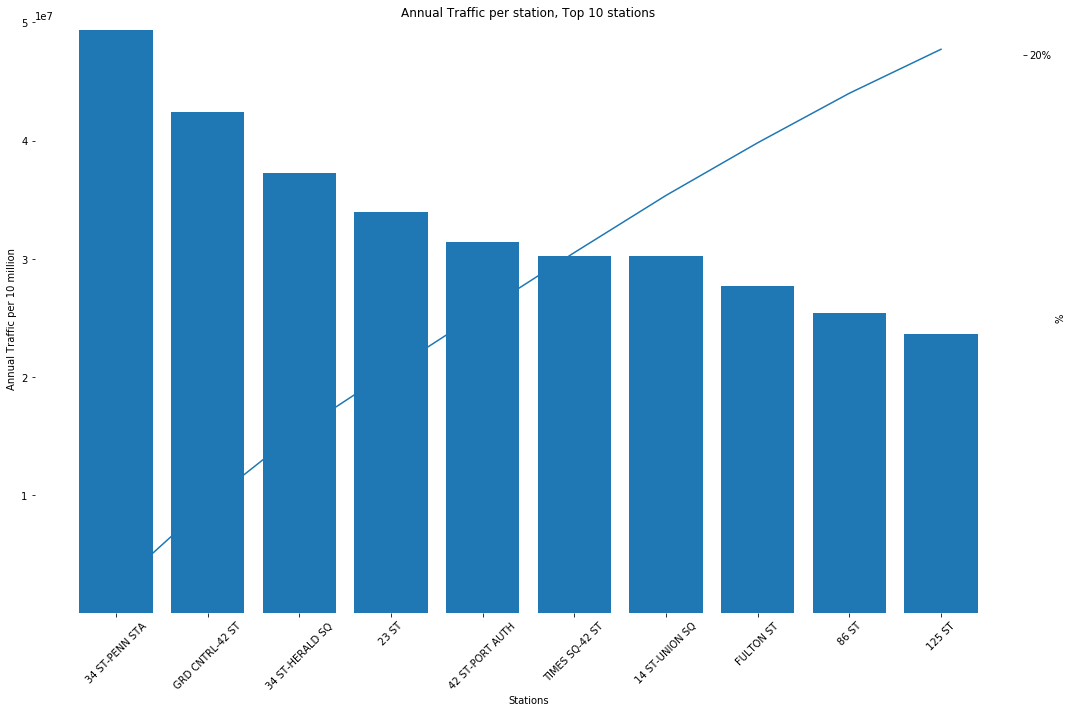

In [148]:
plot_length = 10
fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.bar(x = station_flow.index[:plot_length],height = station_flow[:plot_length])
ax1.set_xticks(np.arange(plot_length))
ax1.set_xticklabels(station_flow.index[:plot_length])
ax1.set_xlabel('Stations')
ax1.set_ylabel('Annual Traffic per 10 million')
plt.title('Annual Traffic per station, Top {} stations'.format(plot_length))
ax1.set_frame_on(False)
ax1.set_ylim([1,5*(10**7)])
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('%')  # we already handled the x-label with ax1
ax2.plot(station_flow.index[:plot_length], station_flow_annual_prc[:plot_length], color=color)
ax2.set_frame_on(False)
ax2.set_yticks([0.2])
ax2.set_yticklabels(['20%'])

fig.tight_layout()  # otherwise the right y-label is slightly clipped


In [149]:
fig.savefig('graph1_10.png')

In [134]:
#Station flow per day

station_flow_day = station_flow_annual /363/24
station_flow_day.sort_values(ascending = False,inplace = True)

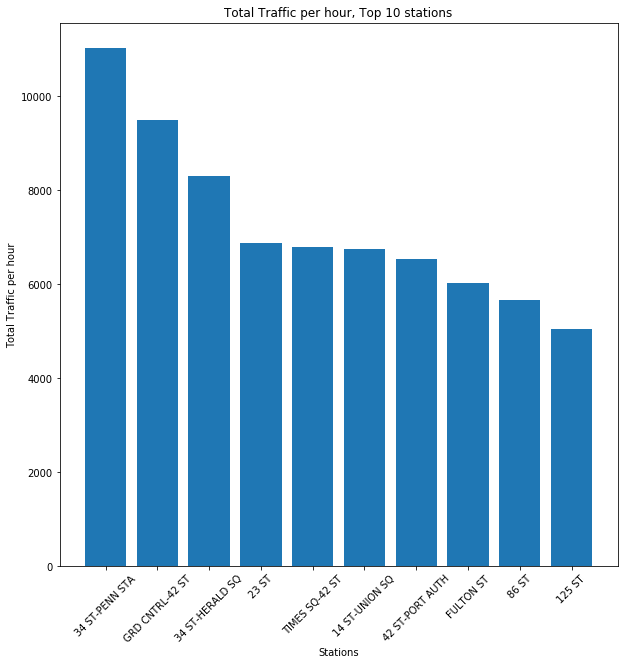

In [160]:
plot_length = 10

plt.figure(figsize=[10,10])
plt.bar(x = station_flow_day.index[:plot_length],height = station_flow_day[:plot_length])
plt.xticks(np.arange(plot_length),station_flow_day.index[:plot_length],rotation=45)
plt.xlabel('Stations')
plt.ylabel('Total Traffic per hour')
plt.title('Total Traffic per hour, Top {} stations'.format(plot_length))

plt.savefig('graph2_10.png')

<Figure size 432x288 with 0 Axes>

343